# Analysis of Algorithms

In [81]:
from load_opb import load_obp_dataset
from linucb import linucb_all

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


## Importing Data

In [82]:
data = load_obp_dataset()
context = data["context"]
action = data["action"]
reward = data["reward"]
n_actions = data["n_actions"]
context_dim = context.shape[1]
alpha = 1.0


INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


## Importing Linear UCB

In [83]:
A = [np.identity(context_dim) for _ in range(n_actions)] #initialized A / V?: design matrix for each action
b = [np.zeros(context_dim) for _ in range(n_actions)] # initialized b: feature vector for each action


results = linucb_all(context, action, reward, A, b, alpha)
for key, value in results.items():
    print(f"{key}: {type(value).__name__}")
# this returns the dictionary from the linucb.py function linucb_all

theta: list
A: list
b: list
chosen_actions: list
true_actions: ndarray
rewards: ndarray
ucb_scores: list


In [84]:
# Print theta estimates

for i, theta in enumerate(results["theta"]):
    print(f"Arm {i} Coefficients: {np.round(theta, 2)}")

# Accuracy or decision match
import matplotlib.pyplot as plt

matches = np.array(results["chosen_actions"]) == np.array(results["true_actions"])
print(f" first few predictions: {results['chosen_actions'][:10]}")
print(f" first few true actions: {results['true_actions'][:10]}")
print(f"Accuracy: {matches.mean() * 100:.2f}%")


Arm 0 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 1 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 2 Coefficients: [ 0.   -0.01 -0.01 -0.    0.   -0.01  0.   -0.    0.    0.   -0.    0.01
  0.02 -0.    0.    0.    0.    0.01 -0.01 -0.  ]
Arm 3 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 4 Coefficients: [ 0.    0.03 -0.01 -0.    0.   -0.   -0.02 -0.02  0.   -0.02 -0.02 -0.01
 -0.02 -0.    0.    0.   -0.    0.    0.02  0.  ]
Arm 5 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 6 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 7 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 8 Coefficients: [-0.   -0.01 -0.01 -0.01  0.   -0.01 -0.01  0.04  0.   -0.   -0.   -0.01
 -0.   -0.    0.   -0.02  0.    0.02  0.   -0.  ]
Arm 9 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

We can observe that we do not have a great accucarcy. However, this might be due to the fact that we calculated the overall accucarcy. Due to the nature of the linear UCB algorithm, the accuracy should get better over time, as we simulte online learning. Let's investigate with a plot:

Cumulative Matches:


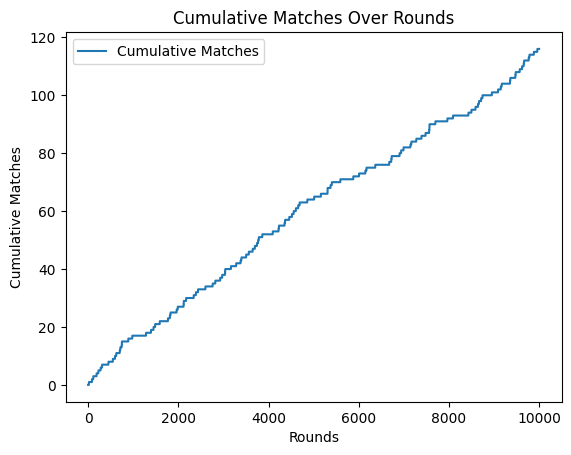

Cumulative Matches: [0 0 0 0 0 0 0 0 0 0]


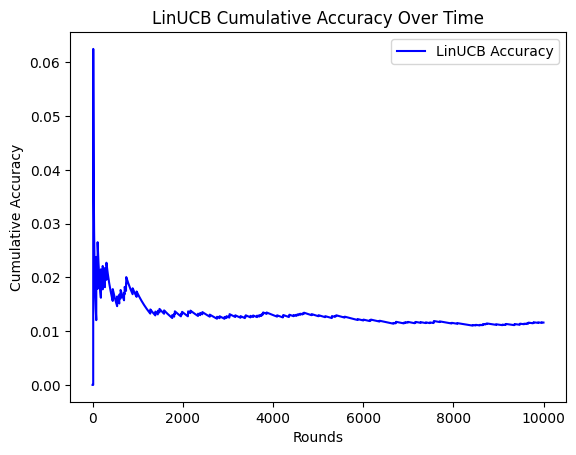

In [85]:

#.figure(figsize=(10, 5))
print("Cumulative Matches:")
plt.plot(np.cumsum(matches), label="Cumulative Matches")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Matches")
plt.title("Cumulative Matches Over Rounds")
plt.legend()
plt.show()

cumulative_matches = np.cumsum(matches)
#print first 10 cumulative matches

print(f"Cumulative Matches: {cumulative_matches[:10]}")
#  calculate accuracy over time

ideal_matches = (np.arange(1, len(matches) + 1))

accuracy_over_time = cumulative_matches / ideal_matches

plt.plot(accuracy_over_time, label='LinUCB Accuracy', color='blue')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Accuracy')
plt.title('LinUCB Cumulative Accuracy Over Time')
plt.legend()
plt.show()

We can see how LinUCB’s selected action rarely matches the action chosen by the logging (random) policy. At first sight, this might seem bad but it is important to remember that we do not model the history action — it is not meaningful in an offline bandit setting. Since the logged actions are random and not necessarily optimal, a low match rate (~1%) simply reflected that LinUCB was learning a different policy, which could be good when we learn the optimal policy. We will check this by investigating the cumulative rewards and compare them with the one of the random policy

## Offline Evaluation under Bandit Feedback

To compare the random policy to the linUCB one, we will use the standard offline bandit evaluation approach and set LinUCB only to receive reward in the rare cases where its selected action matches the one logged by the random policy. However,as a result, most of LinUCB’s potentially good decisions are ignored, leading to a misleadingly low cumulative reward curve. It can be seen in the plot below

To address this, we will implement Inverse Propensity Scoring (IPS), a technique that adjusts for this bias by reweighting observed rewards based on the logging policy's action probabilities. This will allow us to better estimate LinUCB’s true performance despite limited feedback.

In [86]:
print(f"chosen actions: {results['chosen_actions'][:100]}")
print(f"true actions: {results['true_actions'][:100]}")

chosen actions: [0, 1, 2, 3, 4, 0, 5, 6, 7, 8, 2, 0, 1, 1, 9, 10, 3, 11, 12, 13, 14, 15, 4, 16, 17, 18, 7, 5, 19, 20, 21, 22, 23, 6, 24, 8, 25, 10, 26, 27, 9, 12, 11, 14, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 13, 15, 39, 16, 40, 41, 42, 43, 44, 45, 2, 46, 47, 48, 49, 50, 51, 17, 52, 18, 24, 53, 54, 55, 56, 19, 57, 58, 59, 60, 61, 62, 63, 64, 20, 65, 66, 67, 68, 69, 70, 22, 71, 72, 73]
true actions: [14 14 27 48 36  4 70 56 17 55 15 67 45 21 10 10 69 69 43 40 34 68 37 62
 23 79 68 76 16 34 57 29 14 54 31 41 20 73 71 47 78 42 42 74 60 15 43 49
 60 30 22 15 29 77 56 20 63 37 71 13 57 37 31 12 41 36 18 26 29 36  9 11
 50 41 73 33 39 16 37 37 17 43 10 59 64 79 46 22 39 77 55 46 52 12 13 38
  6 14 14 50]


In [87]:
matches

array([False, False, False, ..., False, False, False])

In [88]:
linucb_rewards = np.array(results["rewards"]) * matches

# Optional: convert to list
linucb_rewards = linucb_rewards.tolist()

# Print non-zero rewards
nonzero_rewards = [r for r in linucb_rewards if r > 0]
print(f"Number of valid LinUCB rewards > 0: {len(nonzero_rewards)}")
print(nonzero_rewards[:10])  # first 10


Number of valid LinUCB rewards > 0: 0
[]


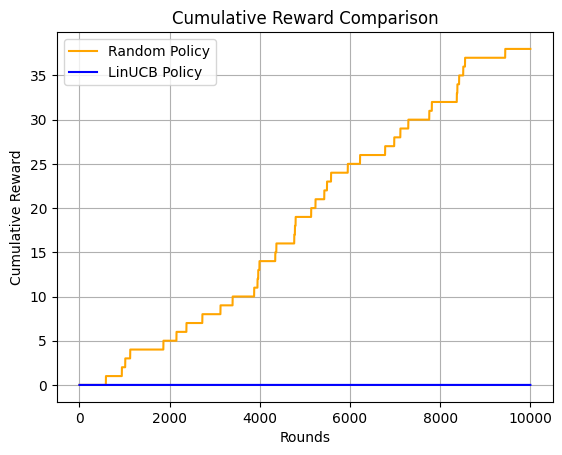

In [89]:

cumulative_random = np.cumsum(data["reward"])

# LinUCB reward
#linucb_reward = np.cumsum(results["rewards"])

plt.plot(cumulative_random, label='Random Policy', color='orange')

plt.plot(linucb_rewards, label='LinUCB Policy', color='blue')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward Comparison')
plt.legend()
plt.grid(True)
plt.show()

## IP

In [90]:
matches.sum()

116

In [91]:
ips_weights.sum()

5120.0

In [96]:
ips_estimates.sum()

0.0

IPS Weights: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
IPS Estimates: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total IPS Estimates: 0.0


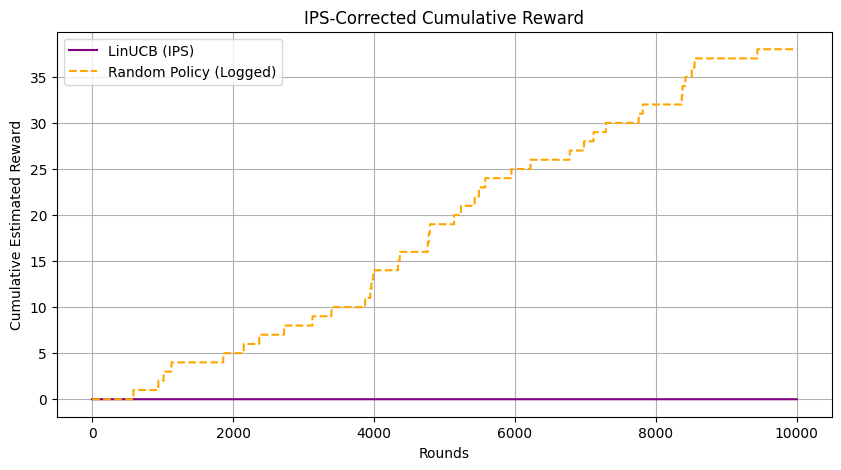

In [98]:
chosen_actions = np.array(results["chosen_actions"])
logged_actions = np.array(data["action"])
rewards = np.array(data["reward"])
pscores = np.array(data["pscore"])

# Indicator: was LinUCB's action equal to the logged one?
matches = chosen_actions == logged_actions

# Apply IPS formula
ips_weights = matches / pscores  # ips_weights = matches / pscores  # (1 / pscore) if match, 0 otherwise
ips_estimates = ips_weights * rewards
print(f"IPS Weights: {ips_weights[:10]}")  # first 10 weights
print(f"IPS Estimates: {ips_estimates[:10]}")  # first 10
print(f"Total IPS Estimates: {ips_estimates.sum()}")
# Cumulative IPS reward over time
cumulative_ips = np.cumsum(ips_estimates)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_ips, label="LinUCB (IPS)", color="purple")
plt.plot(np.cumsum(rewards), label="Random Policy (Logged)", color="orange", linestyle="--")
plt.title("IPS-Corrected Cumulative Reward")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Estimated Reward")
plt.legend()
plt.grid(True)
plt.show()


Again, we do not have any reward for our function:

In our offline evaluation, we observe that LinUCB rarely matches the action selected by the random logging policy, and even when it does, the observed reward is zero. As a result, the Inverse Propensity Scoring (IPS) estimate of LinUCB’s expected reward is also zero. 

However, this should not be interpreted as poor performance. In fact, it indicates that LinUCB is likely learning to avoid the suboptimal actions frequently chosen by the random policy—many of which yield no reward. The problem lies not in the algorithm’s decisions, but in the limitations of offline evaluation: since we only observe rewards for the logged actions, we cannot know the outcomes of the (likely better) actions chosen by LinUCB. This highlights the fundamental challenge of offline bandit evaluation—good policies may appear ineffective simply because their smart choices are not reflected in the logged data.

NEXT UP: 

- Switch to a simulated environment, where we can observe reward for any action.

- Use a better logging policy (not purely random) with more informative data.